# Flux Gaussian Process

In this tutorial, we will show how to infer the spots' contrast and scale of an ensemble of stars, assuming the surfaces of these stars are all drawn from the same stochastic process. This idea was first developed in [Luger 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..124L/abstract) and is based on [expressing the stellar surface as a Gaussian Process](surface_gp.ipynb). For this purpose, spotter implements a [FluxKernel](spotter.kernels.FluxKernel) object parametrized by the surface properties.

## Simulation

Let's start by simulating the light curves of stars seen at different inclinations but whose surfaces are characterized by the same stochastic process. Here, as shown in [a previous tutorial](surface_gp.ipynb), we assume that the stars have spots uniformly distributed on the surface.

In [1]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

from spotter.kernels import GreatCircleDistance
from spotter import Star
import tinygp


def build_kernel(contrast=None, scale=None):
    return contrast * tinygp.kernels.Matern32(scale, distance=GreatCircleDistance())


truth = {"contrast": 0.01, "scale": 0.1}
surface_kernel = build_kernel(**truth)
star = Star.from_sides(10, period=1.0, u=(0.4, 0.3))
surface_gp = tinygp.GaussianProcess(surface_kernel, star.x, diag=1e-6, mean=1.0)

From this surface Gaussian Process, we can sample 50 stars seen at different inclinations

In [2]:
import jax
import matplotlib.pyplot as plt
from spotter.viz import show
import numpy as np

n_samples = 50
y = surface_gp.sample(jax.random.PRNGKey(6), shape=(n_samples,))

# isotropic inclinations sampling
np.random.seed(5)
incs = np.arccos(np.random.uniform(0, 1, n_samples))

```{note}
As you can see we sampled the inclinations isotropically. For an explanation have a look at [how can we most efficiently represent and randomly draw isotropic inclination angles?](https://keatonb.github.io/archivers/uniforminclination).
```

Let's show some of these surfaces

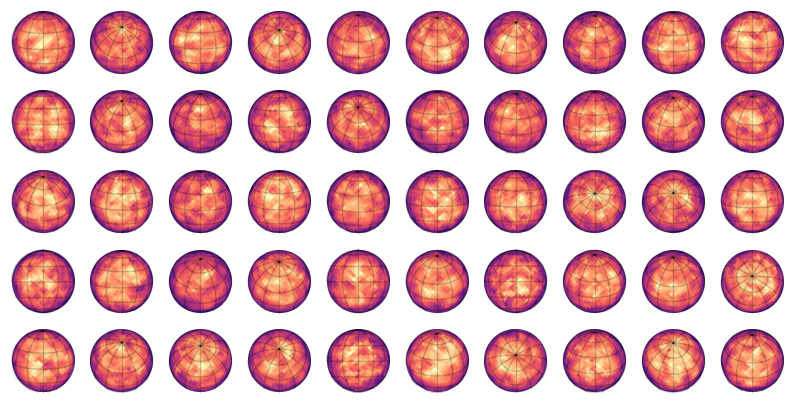

In [3]:
from spotter import show

fig, ax = plt.subplots(5, 10, figsize=(10, 5))
ax = ax.flatten()
for i in range(50):
    show(star.set(y=y[i], inc=incs[i]), ax=ax[i])

Let's now compute the light curves of these surfaces (plus some random noise) and plot them

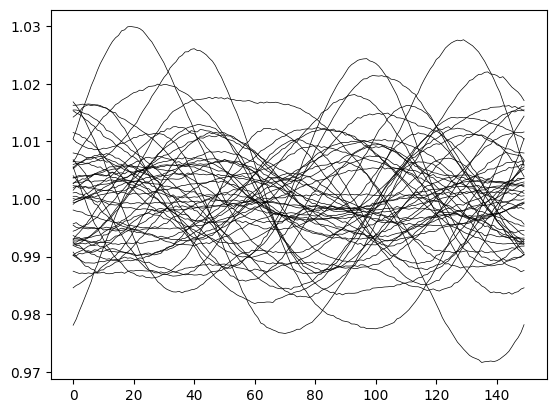

In [4]:
from spotter.light_curves import light_curve

time = np.linspace(0.0, 1.0, 150)
error = 0.0001


def empirical_light_curve(y, inc):
    f = light_curve(star.set(y=y, inc=inc), time, normalize=True)[0]
    return f / np.mean(f) + error * np.random.normal(size=(len(time),))


lcs = np.array([empirical_light_curve(y[i], incs[i]) for i in range(n_samples)])

_ = plt.plot(lcs.T, c="k", lw=0.5)

## Inference

We will now try to infer the spot contrast and scale based on this ensemble of light curves. For that we will implement a numpyro model, that makes use of the [FluxKernel](spotter.kernels.FluxKernel) object.

In [5]:
from spotter.kernels import FluxKernel


def model():
    contrast = numpyro.sample("contrast", numpyro.distributions.Uniform(0.001, 0.8))
    scale = numpyro.sample("scale", numpyro.distributions.Uniform(0.001, 0.8))
    surface_kernel = build_kernel(contrast, scale)
    flux_kernel = FluxKernel(surface_kernel, star, inc=None, order=10, u=star.u[0])
    gp = tinygp.GaussianProcess(flux_kernel, time, mean=1.0, diag=error**2)
    for i in range(len(lcs)):
        numpyro.sample(f"gp_{i}", gp.numpyro_dist(), obs=lcs[i])

We start by finding the maximum likelihood contrast and scale.

In [6]:
import numpyro_ext

run_optim = numpyro_ext.optim.optimize(
    model,
    init_strategy=numpyro.infer.init_to_value(values={"contrast": 0.5, "scale": 0.5}),
)

opt = run_optim(jax.random.PRNGKey(3))

print("\t\ttruth\tmax-lik.")
for var in ["contrast", "scale"]:
    print(f"{var.ljust(10)}\t{truth[var]:.2e}\t{opt[var]:.2e}")

		truth	max-lik.
contrast  	1.00e-02	9.72e-03
scale     	1.00e-01	1.09e-01


We can now move on to the sampling of the posterior likelihood.

In [7]:
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(
    model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_value(values=opt),
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(4)

In [8]:
mcmc.run(rng_key)

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Let's retrieve the sampling chains and print a summary

In [9]:
import arviz as az

inf_data = az.from_numpyro(mcmc)
samples = mcmc.get_samples()
az.summary(inf_data, var_names=["contrast", "scale"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contrast,0.010,0.001,0.008,0.012,0.0,0.0,1588.0,1147.0,1.0
scale,0.108,0.009,0.091,0.124,0.0,0.0,1613.0,1085.0,1.0


Finally, we can draw a corner plot

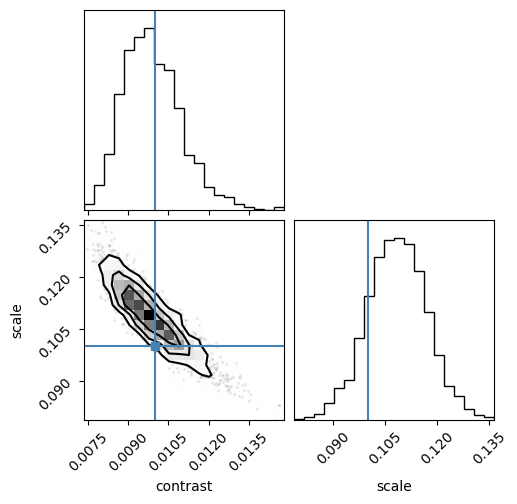

In [10]:
import corner

_ = corner.corner(
    np.array([samples["contrast"], samples["scale"]]).T,
    labels=["contrast", "scale"],
    truths=[truth[t] for t in ["contrast", "scale"]],
)

Given that we are only analyzing 50 light curves of 150 exposure each, not bad!

```{note}
We used a Gaussian process to infer the properties of surfaces from light curves that were not drawn from this Gaussian process. On its own, this is a powerful result.

However, the [FluxKernel](spotter.kernels.FluxKernel) used the **known** surface kernel, which we **never** know in reality. This is a strong prior and doing science with this tool will require an estimate of how much bias choosing a particular kernel introduces to our results. My guess is: *a lot*! 

However, this is not method specific (the active latitude kernel of `starry_process` is a prior on its own) and can be easily tested with spotter. For example, one test could be to generate light curves from surfaces filled with strictly circular spots of the same size, and see if using a surface kernel like the one used in this tutorial allows us to retrieve the spot radii. Another test is to use the wrong kernel (like an [ActiveLatitude kernel](spotter.kernels.ActiveLatitude)) and see if we can retrieve the spot scale using a uniform kernel like the one defined at the beginning of the tutorial.

If you are interested in developing these ideas, open an issue and I'd be happy to help!
```